In [1]:
# Import
import pandas as pd
import numpy as np
import time
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotnine as p9
import plotly.express as px

from numpy.random import normal, uniform
from itertools import combinations
from statsmodels.api import add_constant
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.model_selection import KFold, cross_val_score, train_test_split, LeaveOneOut, ShuffleSplit
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_csv('data/Credit.csv', usecols=range(1,12))
data.head(9)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580
3,148.924,9504,681,3,36,11,Female,No,No,Asian,964
4,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331
5,80.180,8047,569,4,77,10,Male,No,No,Caucasian,1151
6,20.996,3388,259,2,37,12,Female,No,No,African American,203
7,71.408,7114,512,2,87,9,Male,No,No,Asian,872
8,15.125,3300,266,5,66,13,Female,No,No,Caucasian,279


#### Data Preparation

In [10]:
# Splitt data into regressors X and target y and create dummy variables for categorical variables
categ_cols = ["Gender", "Student", "Married", "Ethnicity"]
X = data.loc[:, data.columns != 'Balance']
X = pd.get_dummies(X, columns=categ_cols, drop_first=True)
y = data.loc[:, 'Balance']

#### Lasso Regression

Showing the relative magnitude of the Lasso coefficients

In [4]:
def fit_lasso(X, y, alpha):
    lasso = Lasso()

    # scale the data
    X_scaled = scale(X)

    lasso.set_params(alpha=alpha)
    # fit the model
    lasso.fit(X_scaled, y)

    # show coefficients and their name from dataset
    return lasso.coef_

In [5]:
pd.Series(fit_lasso(X, y, 10**1), index=X.columns)

Income                -228.476604
Limit                  335.295534
Rating                 233.092151
Cards                   12.897087
Age                     -4.058972
Education               -0.000000
Gender_Female           -0.000000
Student_Yes            116.127917
Married_Yes             -0.000000
Ethnicity_Asian          0.000000
Ethnicity_Caucasian      0.000000
dtype: float64

Showing the effect of alpha on the coefficients

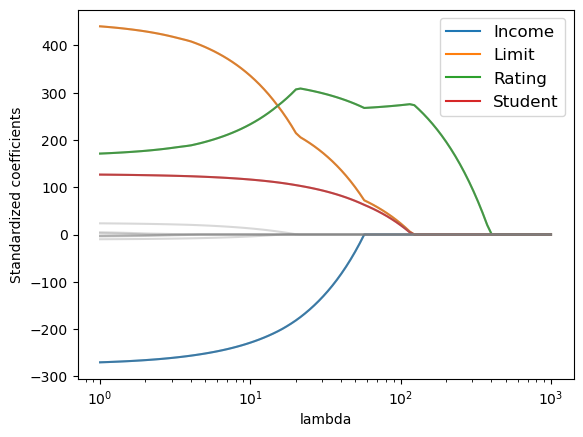

In [6]:
# Init alpha grid
n_grid = 100
alphas = 10**np.linspace(0, 3, n_grid)

lasso = Lasso()
lasso_coefs = []

# Loop over values of alpha
for a in alphas:
    lasso_coefs.append(fit_lasso(X, y, a))
lasso_coefs = np.reshape(lasso_coefs, (n_grid, -1))

highlight = [0,1,2,7]

# Plot coefficients - absolute
fig, ax1 = plt.subplots()
ax1.plot(alphas, lasso_coefs[:,highlight], alpha=1)
ax1.plot(alphas, lasso_coefs, c='grey', alpha=0.3)
ax1.set_xscale('log')
ax1.set_xlabel('lambda')
ax1.set_ylabel('Standardized coefficients')
ax1.legend(['Income', 'Limit', 'Rating', 'Student'], fontsize=12)

Now we tune the hyperparameter alpha using 10-fold cross-validation

In [15]:
# Get MSE
def k_fold_lasso(X, y, a, n_splits=10):
    # Init mse
    X_scaled = scale(X)
    mse = []
    
    # Generate splits
    kf10 = KFold(n_splits=n_splits, random_state=None, shuffle=False)
    kf10.get_n_splits(X_scaled)
    
    # Loop over splits
    for train_index, test_index in kf10.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lasso = Lasso(alpha=a).fit(X_train, y_train)
        y_hat = lasso.predict(X_test)
        mse.append(mean_squared_error(y_test, y_hat))
    return np.mean(mse)

In [18]:
#alphas = np.linspace(0.01, 10, 100)
n_grid = 30
alphas = 10**np.linspace(0,3,n_grid)

# add 0.01 to alphas
alphas = np.append(0.01, alphas)

MSE = [k_fold_lasso(X,y,a,10) for a in alphas]

In [51]:
alpha_min = alphas[np.argmin(MSE)]
print('Best alpha is:', alpha_min)

[10137.24980356544, 10146.95705206272, 10159.068802591715, 10172.40695494983, 10192.081261126645, 10227.378688153109, 10283.072263201451, 10380.956949141062, 10571.30146473752, 10923.22088324424, 11509.562781460136, 12445.332065457535, 13890.980097928472, 16074.492323253487, 19468.041947362846, 24933.04953323338, 33699.88075976543, 46502.66886688982, 51045.13321363651, 57703.34875012038, 67588.51897137903, 76604.62296227434, 90271.57501437204, 112324.4356189149, 147921.40977070518, 204823.44327198956, 212053.98163117282, 212053.98163117282, 212053.98163117282, 212053.98163117282]
Best alpha is: 1.0


#### Post-Lasso

In [50]:
def post_lasso(X, y, alpha):

    coefficients = fit_lasso(X, y, alpha)
    selected_regressors = [X.columns[i] for i,j in enumerate(coefficients) if j != 0]
    X_subset = X.loc[:, selected_regressors]
    X_subset["Student_Yes"] = X_subset["Student_Yes"].astype(int) #TODO this should be dynamic

    # Regress
    # reg = OLS(target, add_constant(X_subset), hasconst=True).fit()
    reg = OLS(y, add_constant(X_subset)).fit()
    return reg.params

    #TODO Auswertung!

print(post_lasso(X, y, 10))

const         -493.734187
Income          -7.795082
Limit            0.193691
Rating           1.091187
Cards           18.211898
Age             -0.624056
Student_Yes    425.609937
dtype: float64
